<a href="https://colab.research.google.com/github/Ahny678/-Speech-Emotion-Recognition-with-Classical-and-Deep-Learning-Models/blob/main/Submission_of_Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PHASE 1: SETUP AND DATA PREPARATIONS**

In [ ]:
import os
import pandas as pd

# 1. Define the dataset root
# root_dir = "/content/ravdess/AUDIODATA"
root_dir ="/content/drive/MyDrive/EMOTION ZIP/AUDIODATA"

# 2. Automatically detect actor folders
actors = sorted([
    f for f in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, f)) and f.startswith("Actor_")
])

print(f"✅ Found {len(actors)} actor folders: {actors[:5]} ...")

# 3. Emotion mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# 4. Parse filenames to extract metadata
filepaths, emotions, actors_list, intensity, statement = [], [], [], [], []

for actor in actors:
    actor_dir = os.path.join(root_dir, actor)
    for file in os.listdir(actor_dir):
        if file.endswith('.wav'):
            parts = file.split('-')
            if len(parts) >= 7:  # ensure valid filename format
                emotion_code = parts[2]
                intensity_code = parts[3]
                statement_code = parts[4]
                emotion_label = emotion_map.get(emotion_code, "unknown")

                filepaths.append(os.path.join(actor_dir, file))
                emotions.append(emotion_label)
                intensity.append(intensity_code)
                statement.append(statement_code)
                actors_list.append(actor)

# 5. Create labeled DataFrame
df = pd.DataFrame({
    'path': filepaths,
    'emotion': emotions,
    'actor_id': actors_list,
    'intensity': intensity,
    'statement': statement
})

# 6. Display summary
print("✅ Dataset summary:")
print(df.head())
print("\nUnique emotions:", df['emotion'].unique())
print("Total samples:", len(df))

# 7. Save for later use
output_csv = '/content/ravdess_labeled.csv'
df.to_csv(output_csv, index=False)
print(f"\n📁 Saved labeled CSV to {output_csv}")


✅ Found 24 actor folders: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05'] ...
✅ Dataset summary:
                                                path  emotion  actor_id  \
0  /content/drive/MyDrive/EMOTION ZIP/AUDIODATA/A...  disgust  Actor_01   
1  /content/drive/MyDrive/EMOTION ZIP/AUDIODATA/A...     calm  Actor_01   
2  /content/drive/MyDrive/EMOTION ZIP/AUDIODATA/A...      sad  Actor_01   
3  /content/drive/MyDrive/EMOTION ZIP/AUDIODATA/A...  neutral  Actor_01   
4  /content/drive/MyDrive/EMOTION ZIP/AUDIODATA/A...    angry  Actor_01   

  intensity statement  
0        02        01  
1        02        01  
2        01        02  
3        01        02  
4        02        02  

Unique emotions: ['disgust' 'calm' 'sad' 'neutral' 'angry' 'happy' 'surprised' 'fearful']
Total samples: 1440

📁 Saved labeled CSV to /content/ravdess_labeled.csv


**PHASE 2: FEATURE EXTRACTION**

In [ ]:
import numpy as np
import librosa
import tqdm
import pandas as pd

# Load your labeled dataset
df = pd.read_csv('/content/ravdess_labeled.csv')

# Feature extraction parameters
n_mfcc = 40  # number of MFCCs to extract

# Lists to store extracted features and labels
X, y = [], []

# Loop through all audio files
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    file_path = row['path']
    emotion = row['emotion']

    try:
        # Load audio file
        y_audio, sr = librosa.load(file_path, sr=None)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=n_mfcc)

        # Take mean across time frames to make it fixed-length
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Basic version — only MFCCs
        X.append(mfccs_mean)
        y.append(emotion)

    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Labels vector shape: {y.shape}")

# Save for model training
np.save('/content/X_features.npy', X)
np.save('/content/y_labels.npy', y)

print("📁 Saved X_features.npy and y_labels.npy")


100%|██████████| 1440/1440 [03:21<00:00,  7.14it/s]

✅ Feature matrix shape: (1440, 40)
✅ Labels vector shape: (1440,)
📁 Saved X_features.npy and y_labels.npy


**PHASE 3: DATA PREPROCESSING**

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load feature and label arrays
X = np.load('/content/X_features.npy')
y = np.load('/content/y_labels.npy')

print(f"Loaded X shape: {X.shape}, y shape: {y.shape}")

# 2. Encode emotion labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("✅ Encoded label classes:", label_encoder.classes_)

# 3. Split into training and testing sets (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 4. Normalize features for ML models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Features normalized (StandardScaler)")

# 5. Save preprocessed data (optional)
np.save('/content/X_train.npy', X_train)
np.save('/content/X_test.npy', X_test)
np.save('/content/y_train.npy', y_train)
np.save('/content/y_test.npy', y_test)

print("📁 Saved preprocessed datasets: X_train, X_test, y_train, y_test")


Loaded X shape: (1440, 40), y shape: (1440,)
✅ Encoded label classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
✅ Train shape: (1152, 40), Test shape: (288, 40)
✅ Features normalized (StandardScaler)
📁 Saved preprocessed datasets: X_train, X_test, y_train, y_test


**PHASE FOUR: MODEL TRAINING: SVM VS RF**

Train shape: (1152, 40), Test shape: (288, 40)

🎯 Training SVM (RBF kernel)...
✅ SVM Accuracy: 0.7049

SVM Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.76      0.73        38
        calm       0.76      0.89      0.82        38
     disgust       0.70      0.74      0.72        38
     fearful       0.75      0.77      0.76        39
       happy       0.74      0.51      0.61        39
     neutral       0.41      0.47      0.44        19
         sad       0.76      0.76      0.76        38
   surprised       0.69      0.62      0.65        39

    accuracy                           0.70       288
   macro avg       0.69      0.69      0.69       288
weighted avg       0.71      0.70      0.70       288


🌲 Training Random Forest...
✅ RF Accuracy: 0.6181

RF Classification Report:
              precision    recall  f1-score   support

       angry       0.78      0.55      0.65        38
        calm       0.58      0.9

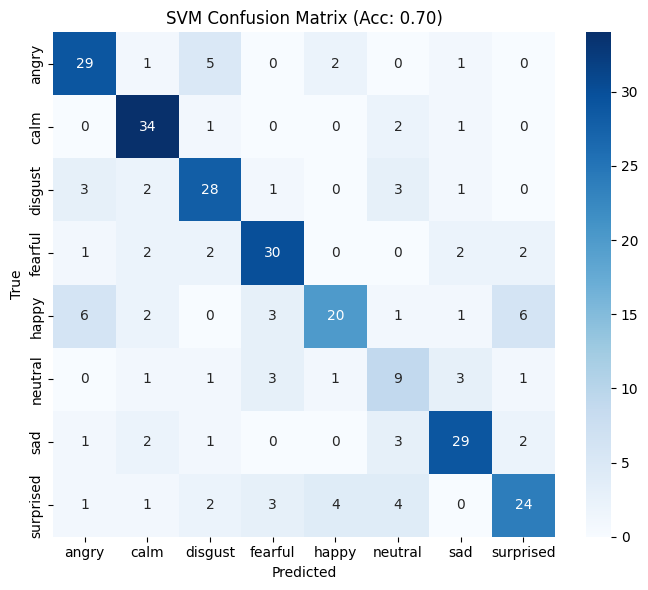

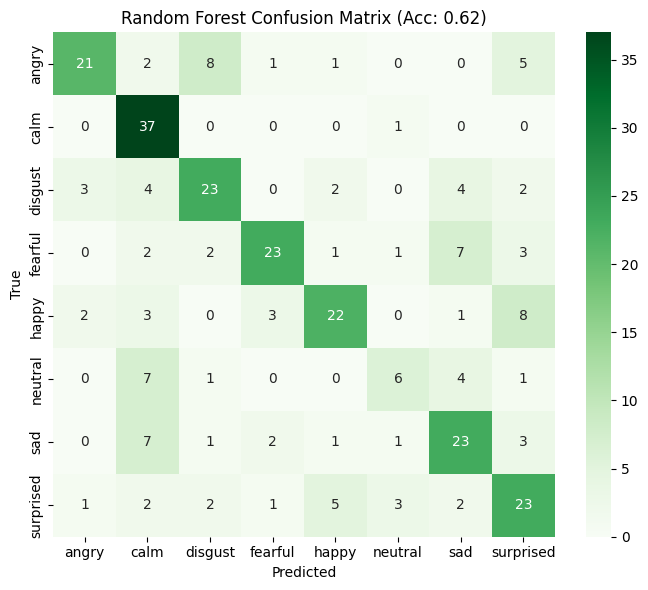

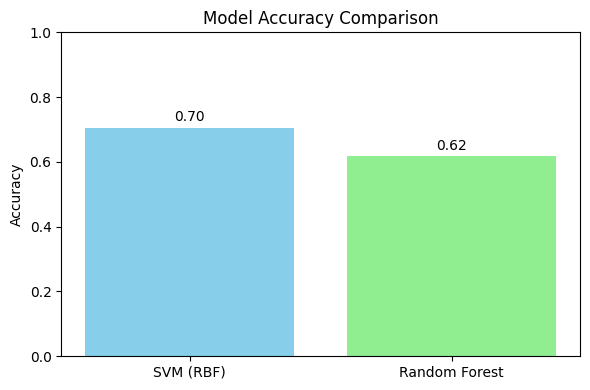

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load preprocessed datasets
X_train = np.load('/content/X_train.npy')
X_test = np.load('/content/X_test.npy')
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Emotion label names (order from LabelEncoder)
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# 2. Train SVM (RBF kernel)
print("\n🎯 Training SVM (RBF kernel)...")
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

svm_acc = accuracy_score(y_test, svm_pred)
print(f"✅ SVM Accuracy: {svm_acc:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred, target_names=emotion_labels))

# 3. Train Random Forest
print("\n🌲 Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
print(f"✅ RF Accuracy: {rf_acc:.4f}")
print("\nRF Classification Report:")
print(classification_report(y_test, rf_pred, target_names=emotion_labels))

# 4. Confusion Matrix — SVM
cm_svm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title(f"SVM Confusion Matrix (Acc: {svm_acc:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 5. Confusion Matrix — Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title(f"Random Forest Confusion Matrix (Acc: {rf_acc:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 6. Accuracy Comparison Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(['SVM (RBF)', 'Random Forest'], [svm_acc, rf_acc], color=['skyblue', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate([svm_acc, rf_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.tight_layout()
plt.show()


**PHASE 5: CNN BASELINE TRAINING**

Train: (1152, 40), Test: (288, 40)
Detected 8 emotion classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 36, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 36, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 32, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,016 (199.28 KB)

 Trainable params: 50,632 (197.78 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.1949 - loss: 2.0807 - val_accuracy: 0.1775 - val_loss: 2.0591
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2634 - loss: 1.9354 - val_accuracy: 0.1688 - val_loss: 2.0742
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2843 - loss: 1.9013 - val_accuracy: 0.1645 - val_loss: 2.0820
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3144 - loss: 1.8200 - val_accuracy: 0.1905 - val_loss: 2.0824
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3445 - loss: 1.7770 - val_accuracy: 0.1991 - val_loss: 2.0789
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3548 - loss: 1.7235 - val_accuracy: 0.2078 - val_loss: 2.0688
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3573 - loss: 1.7120 - val_accuracy: 0.2078 - val_loss: 2.0561
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3672 - loss: 1.6879 - val_accuracy: 0.2035 - v

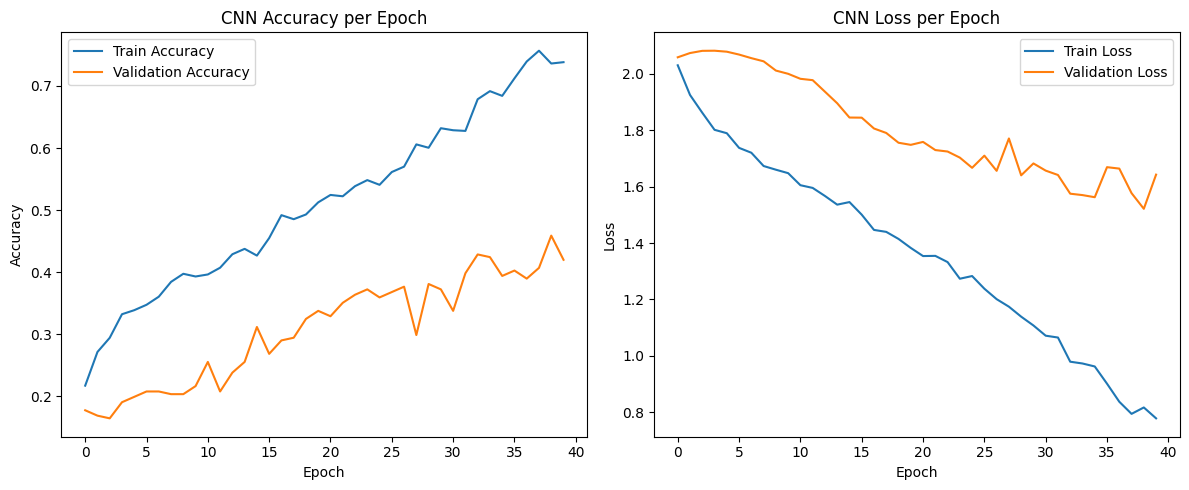

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


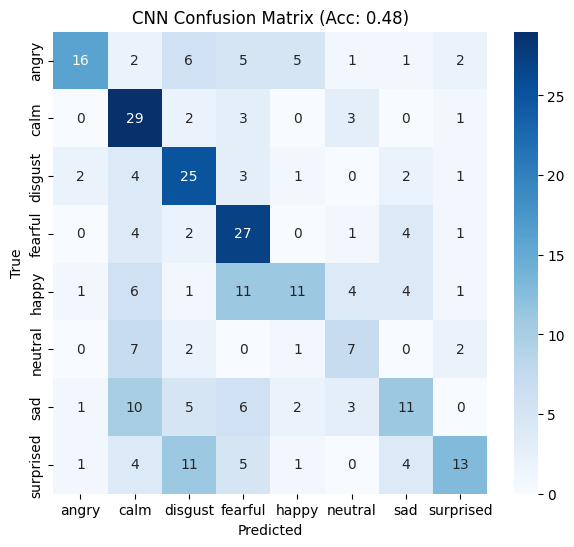


Classification Report (CNN):
              precision    recall  f1-score   support

       angry       0.76      0.42      0.54        38
        calm       0.44      0.76      0.56        38
     disgust       0.46      0.66      0.54        38
     fearful       0.45      0.69      0.55        39
       happy       0.52      0.28      0.37        39
     neutral       0.37      0.37      0.37        19
         sad       0.42      0.29      0.34        38
   surprised       0.62      0.33      0.43        39

    accuracy                           0.48       288
   macro avg       0.51      0.48      0.46       288
weighted avg       0.52      0.48      0.47       288



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load preprocessed data
X_train = np.load('/content/X_train.npy')
X_test = np.load('/content/X_test.npy')
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# 2. Reshape for CNN input (samples, features, 1 channel)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

num_classes = len(np.unique(y_train))
print(f"Detected {num_classes} emotion classes.")

# 3. Build a simple CNN model
model = models.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# 4. Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 5. Train the CNN
history = model.fit(
    X_train_cnn, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"✅ CNN Test Accuracy: {test_acc:.4f}")

# 7. Training/Validation Accuracy and Loss Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Confusion Matrix
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

cm = confusion_matrix(y_test, y_pred)
emotion_labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title(f'CNN Confusion Matrix (Acc: {test_acc:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9. Detailed Classification Report
print("\nClassification Report (CNN):")
print(classification_report(y_test, y_pred, target_names=emotion_labels))
